### To Do
- [x] add real err computations
- [ ] compute box-plot metrics, not just mean

#### Metrics
- % alts w/ uncorrected samp. prob > pop. mean prob: should decrease as $N_s$ --> $N_p$
- avg. (max corrected samp. prob - true max prob): should approach zero as $N_s$ --> $N_p$

#### Notes
- bias of naive correction factor estimator seems very related to "spikey-ness" of distribution. but mean abs err does not!
- probability distribution seems to get less spikey with more parameters
- Spikey-ness is a function of model error!

In [62]:
import numpy as onp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [63]:
import matplotlib as mpl
import statsmodels.api as sm

In [66]:
metrics = pd.read_csv('../iter_err_metrics.csv')

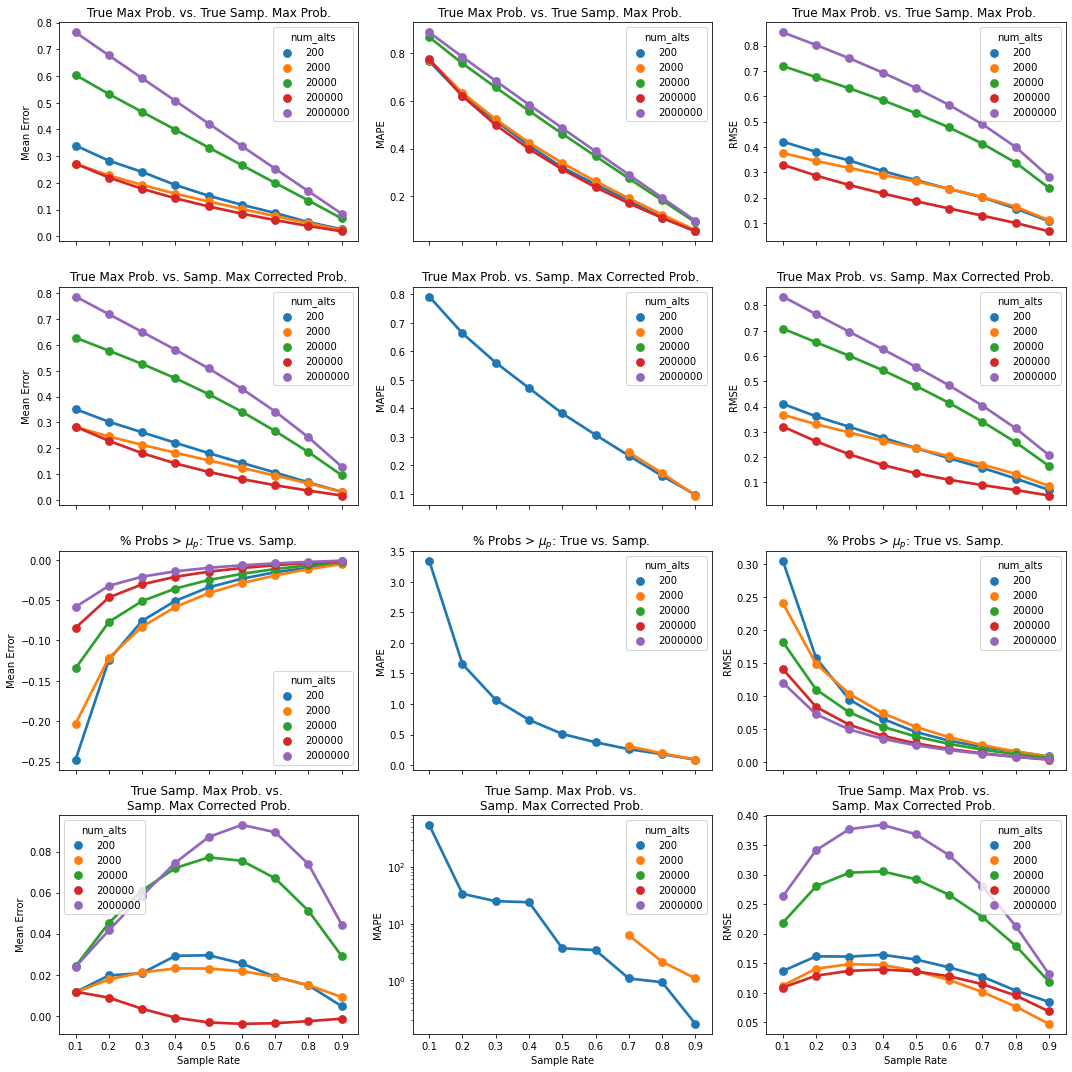

In [67]:
fig, axarr = plt.subplots(4, 3, figsize=(15, 15), sharex=True)

sns.pointplot(data=metrics, x='sample_rate', y ='tmsm_mean_err', hue='num_alts', ax=axarr[0, 0])
axarr[0, 0].set_title("True Max Prob. vs. True Samp. Max Prob.", fontsize=12)
axarr[0, 0].set_ylabel("Mean Error")
axarr[0, 0].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='tmsm_mean_abs_pct_err', hue='num_alts', ax=axarr[0, 1])
axarr[0, 1].set_title("True Max Prob. vs. True Samp. Max Prob. ", fontsize=12)
axarr[0, 1].set_ylabel("MAPE")
axarr[0, 1].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='tmsm_rmse', hue='num_alts', ax=axarr[0, 2])
axarr[0, 2].set_title("True Max Prob. vs. True Samp. Max Prob. ", fontsize=12)
axarr[0, 2].set_ylabel("RMSE")
axarr[0, 2].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='tmsmc_mean_err', hue='num_alts', ax=axarr[1, 0])
axarr[1, 0].set_title("True Max Prob. vs. Samp. Max Corrected Prob.", fontsize=12)
axarr[1, 0].set_ylabel("Mean Error")
axarr[1, 0].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='tmsmc_mean_abs_pct_err', hue='num_alts', ax=axarr[1, 1])
axarr[1, 1].set_title("True Max Prob. vs. Samp. Max Corrected Prob. ", fontsize=12)
axarr[1, 1].set_ylabel("MAPE")
axarr[1, 1].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='tmsmc_rmse', hue='num_alts', ax=axarr[1, 2])
axarr[1, 2].set_title("True Max Prob. vs. Samp. Max Corrected Prob.", fontsize=12)
axarr[1, 2].set_ylabel("RMSE")
axarr[1, 2].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='ppgm_mean_err', hue='num_alts', ax=axarr[2, 0])
axarr[2, 0].set_title("% Probs > $\mu_p$: True vs. Samp. ", fontsize=12)
axarr[2, 0].set_ylabel("Mean Error")
axarr[2, 0].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='ppgm_mean_abs_pct_err', hue='num_alts', ax=axarr[2, 1])
axarr[2, 1].set_title("% Probs > $\mu_p$: True vs. Samp. ", fontsize=12)
axarr[2, 1].set_ylabel("MAPE")
axarr[2, 1].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='ppgm_rmse', hue='num_alts', ax=axarr[2, 2])
axarr[2, 2].set_title("% Probs > $\mu_p$: True vs. Samp. ", fontsize=12)
axarr[2, 2].set_ylabel("RMSE")
axarr[2, 2].set_xlabel("")

sns.pointplot(data=metrics, x='sample_rate', y ='cf_mean_err', hue='num_alts', ax=axarr[3, 0])
axarr[3, 0].set_title("True Samp. Max Prob. vs. \nSamp. Max Corrected Prob.", fontsize=12)
axarr[3, 0].set_ylabel("Mean Error")
axarr[3, 0].set_xlabel("Sample Rate")

sns.pointplot(data=metrics, x='sample_rate', y ='cf_mean_abs_pct_err', hue='num_alts', ax=axarr[3, 1])
axarr[3, 1].set_title("True Samp. Max Prob. vs. \nSamp. Max Corrected Prob.", fontsize=12)
axarr[3, 1].set_ylabel("MAPE")
axarr[3, 1].set_yscale("log")
axarr[3, 1].set_xlabel("Sample Rate")

sns.pointplot(data=metrics, x='sample_rate', y ='cf_rmse', hue='num_alts', ax=axarr[3, 2])
axarr[3, 2].set_title("True Samp. Max Prob. vs. \nSamp. Max Corrected Prob. ", fontsize=12)
axarr[3, 2].set_ylabel("RMSE")
axarr[3, 2].set_xlabel("Sample Rate")

fig.tight_layout()

# BACKUP

Text(0.5, 0, 'Sample Rate')

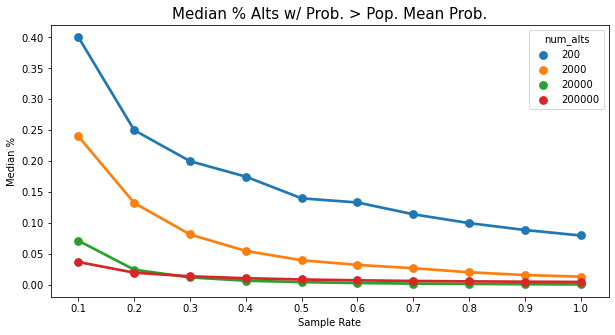

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=metrics, x='sample_rate', y ='med_pct_probs_gt_pop_mean', hue='num_alts', ax=ax)
ax.set_title("Median % Alts w/ Prob. > Pop. Mean Prob.", fontsize=15)
ax.set_ylabel("Median %")
ax.set_xlabel("Sample Rate")

Text(0.5, 0, 'Sample Rate')

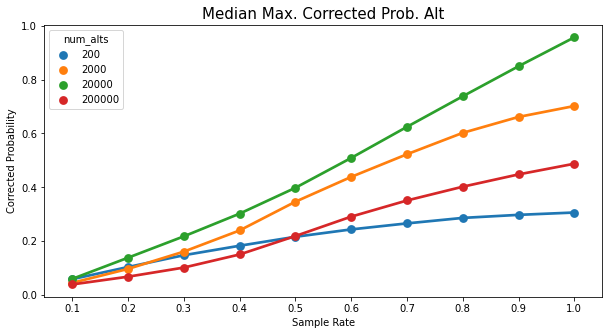

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=metrics, x='sample_rate', y ='med_max_corr_prob', hue='num_alts', ax=ax)
ax.set_title("Median Max. Corrected Prob. Alt", fontsize=15)
ax.set_ylabel("Corrected Probability")
ax.set_xlabel("Sample Rate")

In [ ]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         samp_corr_maxs = sample_size_data['probs_samp_corr'].max(axis=1)
#         g = sns.kdeplot(samp_corr_maxs, fill=True,ax=axarr[i], label=str(sample_size))
#         polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#         color = polys[-1].get_facecolor()
#         axarr[i].vlines(onp.nanmedian(samp_corr_maxs), 0, 20, lw=1, color=color, alpha=1, linestyle='--')
#     probs_true_max = n_alts_data[1]['probs_true'].max(axis=1)
#     g = sns.kdeplot(probs_true_max, fill=True, ax=axarr[i], label=str(1), lw=3)
#     polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#     color = polys[-1].get_facecolor()
#     axarr[i].vlines(onp.nanmedian(probs_true_max), 0, 20, lw=2, color=color, alpha=1)
#     axarr[i].legend(title='Sample Rate')
#     axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)
# fig.suptitle("Max. Corrected Probability Across Choosers", fontsize=20)

In [ ]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         samp_maxs = sample_size_data['probs_true_samp'].max(axis=1)
#         g = sns.kdeplot(samp_maxs, fill=True, ax=axarr[i], label=str(sample_size))
#         polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#         color = polys[-1].get_facecolor()
#         axarr[i].vlines(onp.nanmedian(samp_maxs), 0, 10, lw=1, color=color, alpha=1, linestyle='--')
#     probs_true_max = n_alts_data[1]['probs_true'].max(axis=1)
#     g = sns.kdeplot(probs_true_max, fill=True, ax=axarr[i], label=str(1), lw=3, )
#     polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#     color = polys[-1].get_facecolor()
#     axarr[i].vlines(onp.nanmedian(probs_true_max), 0, 10, lw=2, color=color,alpha=1, )
#     axarr[i].legend(title='Sample Rate')
#     axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)
# fig.suptitle("Max. True Probability Across Choosers", fontsize=20)

In [ ]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
    
#     probs_true = n_alts_data[1]['probs_true']
#     true_massing = np.nansum(probs_true, axis=0)
#     order = true_massing.argsort()[::-1]
#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
            
#         probs_samp_sparse = sample_size_data['probs_samp_sparse']
#         sampled_massing = np.nansum(probs_samp_sparse, axis=0)
#         massing_err = (true_massing - sampled_massing)
#         z = sm.nonparametric.lowess(massing_err[order], true_massing[order], frac=1/20, it=6)
#         axarr[i].plot(z[:,0], z[:,1], lw=1, alpha=0.4)
#         axarr[i].scatter(true_massing[order], massing_err[order], marker='o', label=str(sample_size), alpha=0.5)

#     axarr[i].axhline(y=0, color='k', linestyle='--', lw=0.5)

#     axarr[i].legend(title='Sample Rate')
#     axarr[i].set_ylabel('Error')
#     axarr[i].set_xscale('log')
#     axarr[i].set_yscale('symlog')
#     axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)

# axarr[i].set_xlabel('True Probability Mass')

# fig.suptitle("Probability Massing Error", fontsize=20)
# fig.tight_layout()

In [ ]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
    
#     probs_true = n_alts_data[1]['probs_true']
#     true_massing = np.nansum(probs_true, axis=0) / probs_true.shape[0]
#     order = true_massing.argsort()[::-1]

#     axarr[i].plot(range(num_alts), true_massing[order], color='b', alpha=.5, label='True')

#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         probs_samp_sparse = sample_size_data['probs_samp_sparse']
#         samp_massing = np.nansum(probs_samp_sparse, axis=0) / probs_true.shape[0]
#         axarr[i].plot(range(num_alts), samp_massing[order], label=sample_size, lw=0.5)

#         axarr[i].legend(title='Sample Rate')
#         axarr[i].set_title('', fontsize=15)
#         axarr[i].set_ylabel('% Probability Mass')
#         axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)

# axarr[i].set_xlabel('Alternative ID')

# fig.suptitle("Probability Massing of Alts - Sorted by True Prob. Mass", fontsize=20)
# fig.tight_layout()

In [ ]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
    
#     probs_true = n_alts_data[1]['probs_true']
#     true_massing = np.nansum(probs_true, axis=0) / probs_true.shape[0]
#     order = true_massing.argsort()[::-1]

#     axarr[i].plot(range(num_alts), true_massing[order], color='b', alpha=.5, label='True')

#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         probs_samp_sparse = sample_size_data['probs_samp_sparse']
#         samp_massing = np.nansum(probs_samp_sparse, axis=0) / probs_true.shape[0]
#         axarr[i].plot(range(num_alts), samp_massing[order], label=sample_size, lw=0.5)

#         axarr[i].legend(title='Sample Rate')
#         axarr[i].set_title('', fontsize=15)
#         axarr[i].set_ylabel('% Probability Mass')
#         axarr[i].set_xlim(-1, 50)
#         axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)

# axarr[i].set_xlabel('Alternative ID')

# fig.suptitle("Probability Massing of Top 50 Alts - Sorted by True Prob. Mass", fontsize=20)
# fig.tight_layout()